# ♠️ ♥️ Identificando naipes de cartas de baralho ♦️ ♣️

Disponível em: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification

Ou seja, um problema de classificação!

## Características do dataset

O dataset contém 7624 imagens de treino, 265 imagens de teste e 265 imagens de validação.



## Divisão do dataset

O dataset está dividido em 53 pastas, sendo uma pasta para cada tipo de carta (13 * 4 + Joker (que não tem Naipe)).

### Pastas
Como o dataset está dividido em: Cada pasta é uma classe de carta, o nome da pasta é o rótulo da classe, ou seja, dentro das pastes de test, train e valid tem pastas com os nomes "ace of hearts" (Ás de copas), "eight of spades" (Oito de espadas) etc.

### Arquivos
Os arquivos do dataset estão em .jpg (as imagens dos naipes em si) e .Identifier.


## Visualizando o HOG

Vamos entender melhor como funcionar o descritor:

In [11]:
from skimage.feature import hog
import matplotlib.pyplot as plt
import cv2

def show_hog_visualization(image_path):
    # Carrega imagem
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Extrai HOG + imagem visual
    features, hog_image = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True
    )

    # Mostra lado a lado
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Imagem original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(hog_image, cmap='gray')
    plt.title("HOG (visão do modelo)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


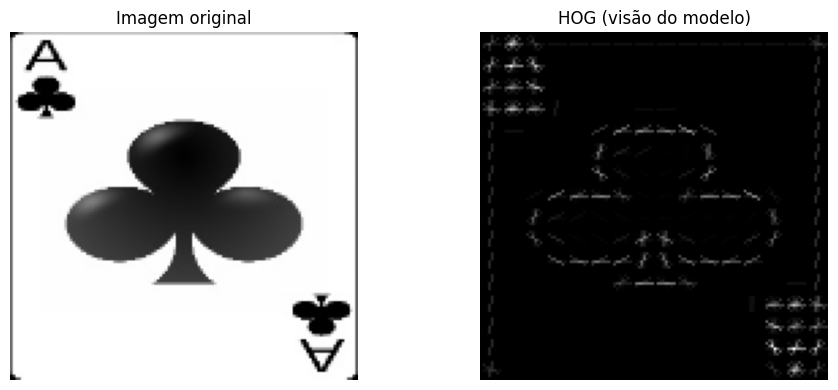

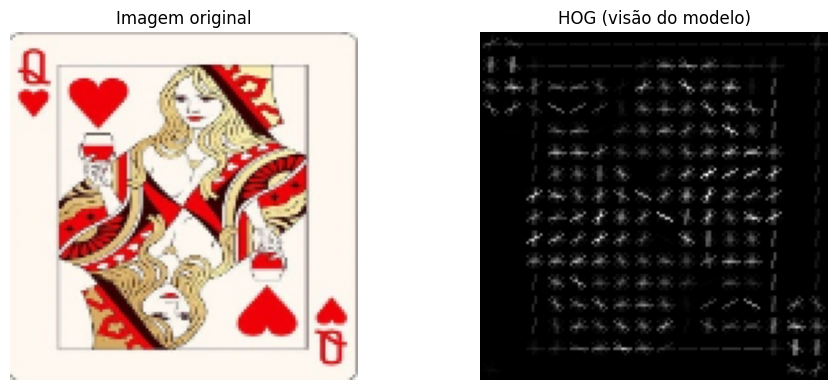

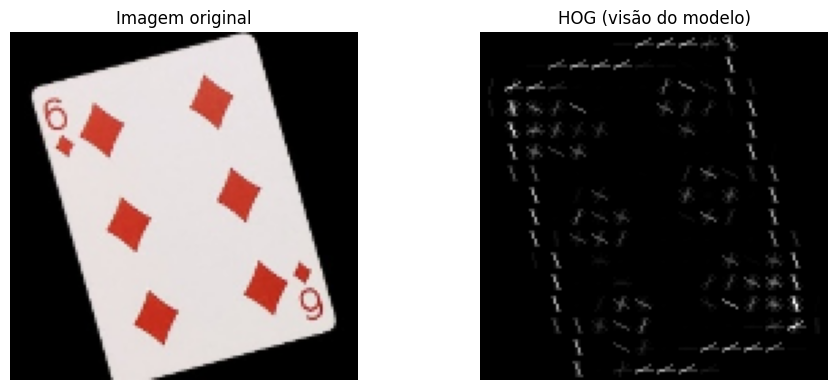

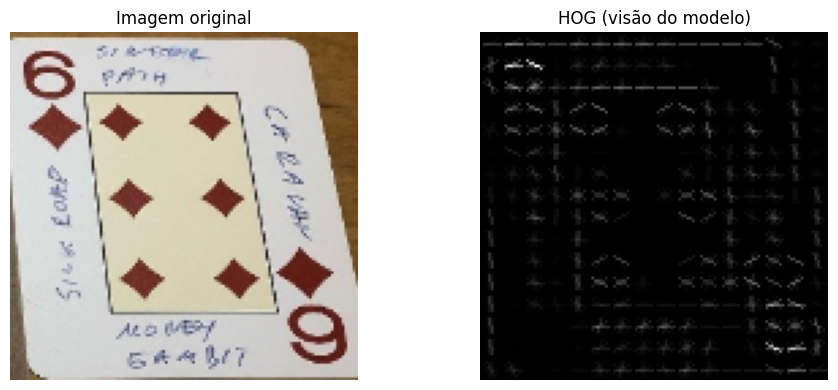

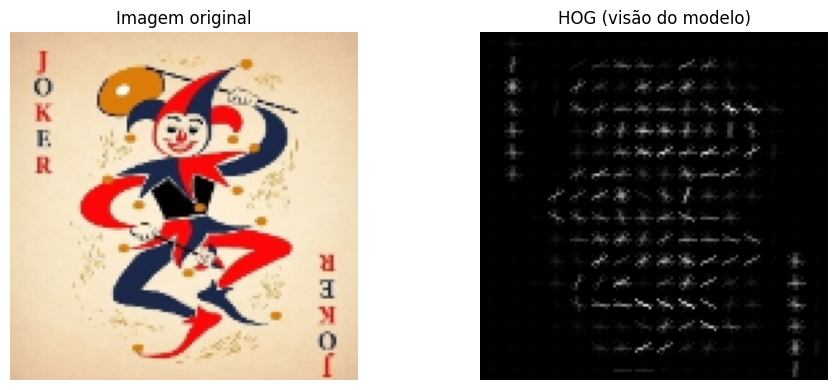

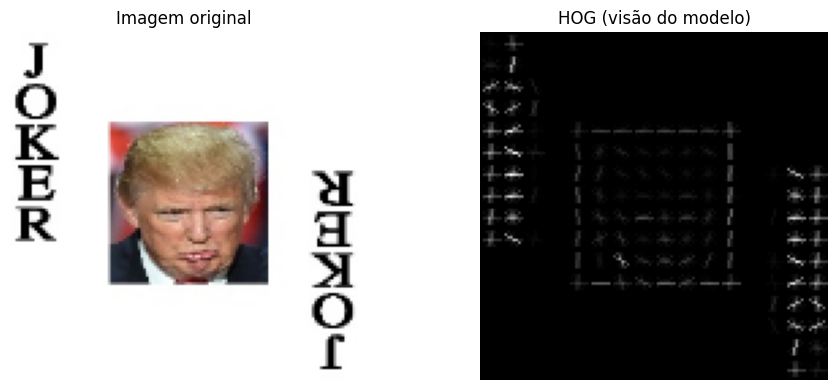

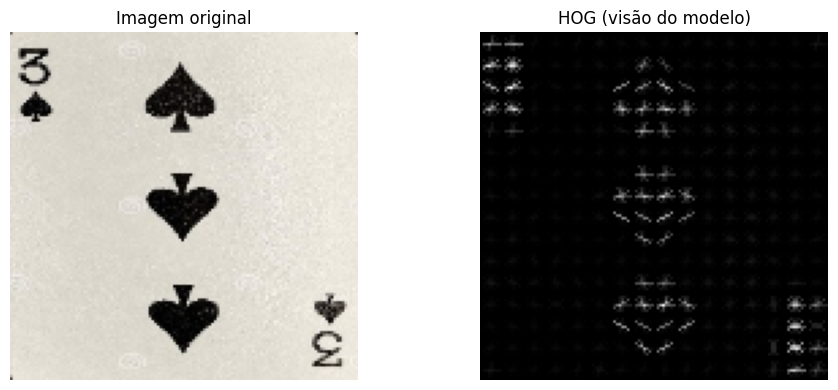

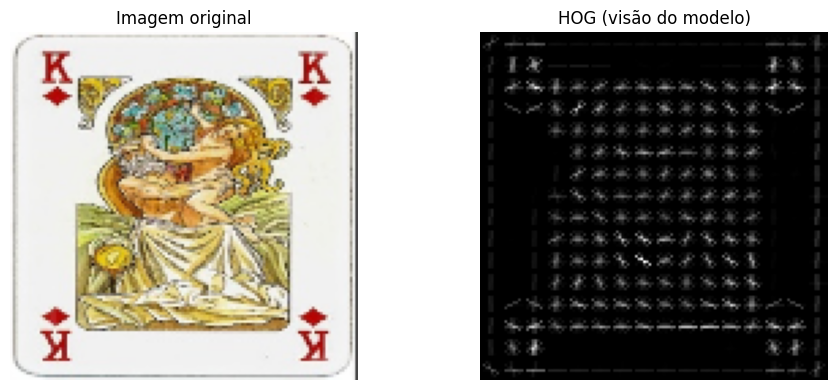

In [12]:
show_hog_visualization("imgs/cards/train/ace of clubs/003.jpg")
show_hog_visualization("imgs/cards/train/queen of hearts/040.jpg")
show_hog_visualization("imgs/cards/train/six of diamonds/001.jpg")
show_hog_visualization("imgs/cards/train/six of diamonds/005.jpg")
show_hog_visualization("imgs/cards/train/joker/075.jpg")
show_hog_visualization("imgs/cards/test/joker/5.jpg")
show_hog_visualization("imgs/cards/train/three of spades/008.jpg")
show_hog_visualization("imgs/cards/train/king of diamonds/046.jpg")

## Implementação

In [13]:
import matplotlib.pyplot as plt
def show_img(image):
    plt.figure()
    plt.imshow(image)
    plt.axis("off")

In [34]:
import os
import cv2

# Pesquisando, vi que o hog da scikit image se integra melhor com o SVM
from skimage.feature import hog

def load_images_and_labels(root_dir):
  X, y, paths_img = [], [], []
  for label in os.listdir(root_dir):
    # Para cada label, vamos concatenar com o caminho inteiro do diretorio informado
    class_dir = os.path.join(root_dir, label)
    for file in os.listdir(class_dir):

      # Como nas pastas tem os arquivo .Identifier também, temos que ignorá-los.
      if file.lower().endswith((".jpg")):
        img_path = os.path.join(class_dir, file)
        img = cv2.imread(img_path)

        # Redimensionando para ficar num tamanho padrão (Lembrando que originalmente
        # as imagems estão em 224x224)
        img = cv2.resize(img, (128, 128))

        # Convertendo para a escala de cinza (porque funciona melhor com o HOG)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Extraimos o HOG das imagens
        features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), block_norm='L2-Hys') # L2-Hys == Normalização. Torna menos sensivel a brilho/contraste
        
        # Inserindo o vetor HOG no conjunto de dados
        X.append(features)

        # Armazenando o nome da classe (nome da pasta) como labels
        y.append(label)

        # Armazena o caminho das imagens
        paths_img.append(img_path)
  # Ou seja, retorna features = [[0.0, 0.12, 0.45, ..., 0.01]] / [Nome_da_classe, Nome_da_classe2]
  return X, y, paths_img # O scikit-learn converte o y automaticamente com o LabelEncoder()


### Carregando as imagens

In [35]:
X_train, y_train, _ = load_images_and_labels("imgs/cards/train")
X_valid, y_valid, _ = load_images_and_labels("imgs/cards/valid")
X_test, y_test, paths_test = load_images_and_labels("imgs/cards/test")

#### Assim temos
X = lista de vetores de características

y = lista de rótulos (labels)

### Criando o modelo

#### Ajustando os hiperparâmetros (C) com o conjunto X_valid

Lembrando que C, no SVC é o quanto o modelo aceita errar.

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score

melhor_f1_score = 0
melhor_c = None
melhor_modelo_svc = None

valores_c = [0.01, 0.1, 1, 10]
historico_f1_scores = []

# Lembrando que o padrao do SVC é 1
for C in valores_c:
  modelo_svc = SVC(kernel="linear", C=C)
  modelo_svc.fit(X_train, y_train)

  y_valid_pred = modelo_svc.predict(X_valid)
  pnts_f1_score = f1_score(y_valid, y_valid_pred, average="macro")
  historico_f1_scores.append(pnts_f1_score)
  if(pnts_f1_score > melhor_f1_score):
    melhor_f1_score = pnts_f1_score
    melhor_c = C
    melhor_modelo_svc = modelo_svc

print("\n>> Melhor valor de C: %.2f\n" %melhor_c)
print("\n>>Melhor F1 Score: %.2f" %melhor_f1_score)



>> Melhor valor de C: 0.10


>>Melhor F1 Score: 0.78


### Vendo os gráficos de hiperparâmetros

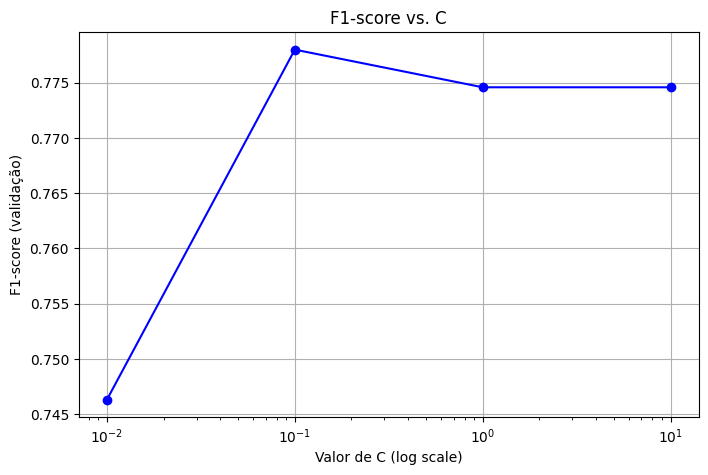

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(valores_c, historico_f1_scores, marker='o', linestyle='-', color='blue')
plt.xscale('log')  # Escala logarítmica facilita ver padrões
plt.xlabel("Valor de C (Escala Logarítmica)")
plt.ylabel("F1-score (validação)")
plt.title("F1-score vs. C")
plt.grid(True)
plt.show()

### Validação com o conjunto de testes

In [ ]:
# Avaliação final com X_test
y_test_pred = melhor_modelo_svc.predict(X_test)
print("\nAvaliação no conjunto de TESTE:")
print(classification_report(y_test, y_test_pred))


📊 Avaliação no conjunto de TESTE:
                   precision    recall  f1-score   support

     ace of clubs       0.50      0.80      0.62         5
  ace of diamonds       1.00      1.00      1.00         5
    ace of hearts       0.83      1.00      0.91         5
    ace of spades       0.67      0.80      0.73         5
   eight of clubs       0.38      1.00      0.56         5
eight of diamonds       0.60      0.60      0.60         5
  eight of hearts       1.00      0.80      0.89         5
  eight of spades       0.80      0.80      0.80         5
    five of clubs       1.00      0.60      0.75         5
 five of diamonds       0.75      0.60      0.67         5
   five of hearts       0.83      1.00      0.91         5
   five of spades       1.00      0.80      0.89         5
    four of clubs       0.50      0.80      0.62         5
 four of diamonds       0.71      1.00      0.83         5
   four of hearts       1.00      0.80      0.89         5
   four of spades   

Apenas mostrando visualmente que a scikit-learn, para o SVM, entende as labels em string.

In [19]:
print("\nValores únicos: %d" %len(list(set(y_test_pred))))


Valores únicos: 53


#### Matriz de confusão

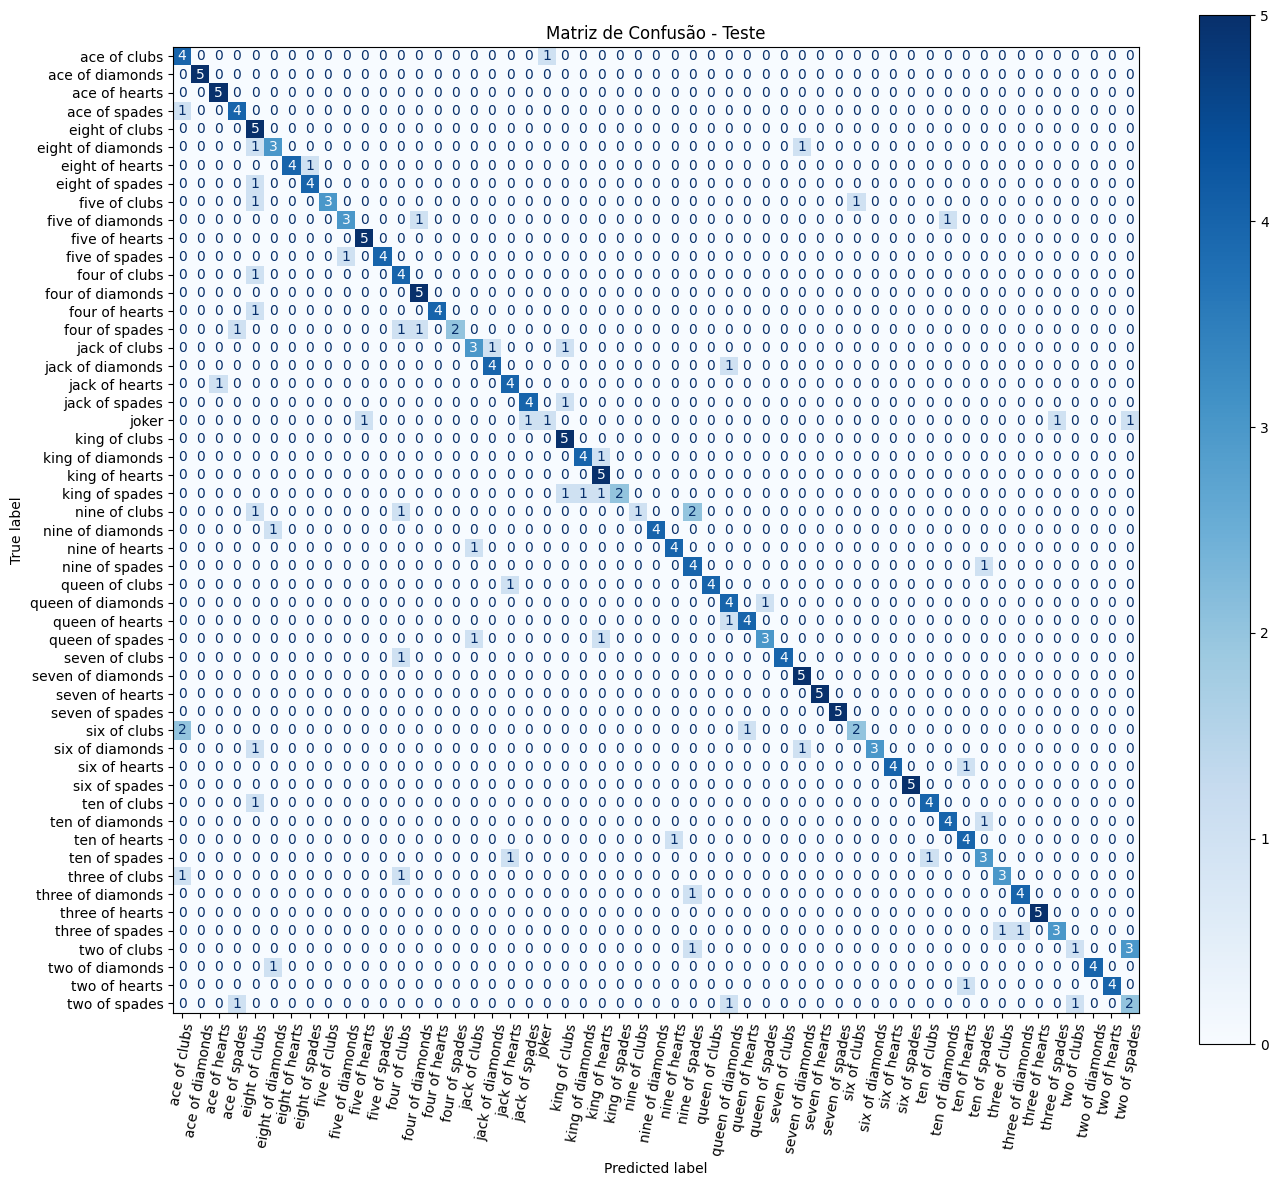

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Matriz
cm = confusion_matrix(y_test, y_test_pred, labels=melhor_modelo_svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=melhor_modelo_svc.classes_)


fig, ax = plt.subplots(figsize=(14, 12))  
disp.plot(ax=ax, xticks_rotation=80, cmap="Blues")

plt.title("Matriz de Confusão - Teste")
plt.grid(False)
plt.tight_layout()
plt.show()


### Quais imagens o modelo errou?

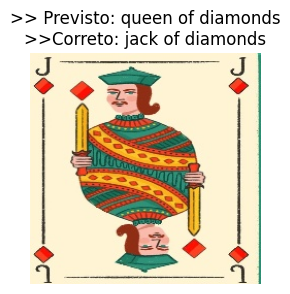

imgs/cards/test/jack of diamonds/3.jpg


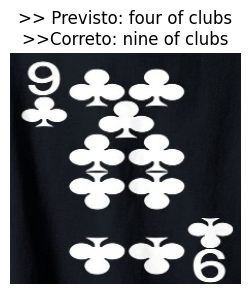

imgs/cards/test/nine of clubs/5.jpg


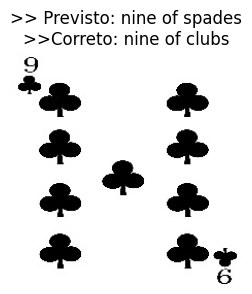

imgs/cards/test/nine of clubs/1.jpg


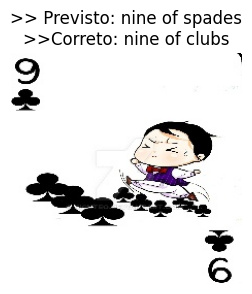

imgs/cards/test/nine of clubs/2.jpg


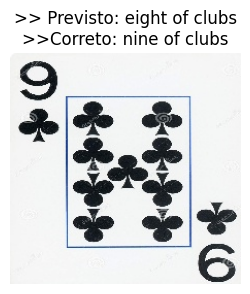

imgs/cards/test/nine of clubs/4.jpg


In [42]:
# Vamos refazer as predições
y_pred = melhor_modelo_svc.predict(X_test)

# Apenas limitando a quantidade de erros mostrados
erros_mostrados = 0
maximo_erros = 5
                                        # O zip serve para iterar os três de uma vez
for img_path, true_label, pred_label in zip(paths_test, y_test, y_pred):
  if true_label != pred_label:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.title(f">> Previsto: {pred_label}\n>>Correto: {true_label}")
    plt.axis("off")
    plt.show()

    print(img_path)
    erros_mostrados += 1
    if erros_mostrados >= maximo_erros:
      break


### Resultados

Como podemos ver no classification report, o modelo acerta 100% alguns naipes, tendo uma acurácia de 75% e um f1 score médio de 74%.

Dado a quantidade de imagens de treino (mais de 7 mil imagens), o modelo se saiu muito bem nos testes.